In [ ]:
import numpy as np
import tensorflow as tf
import random as rn
import os

seed_value = 34

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_value)
rn.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

# import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


Tensorflow version: 2.8.0


## Hyperparameters

In [ ]:
! nvidia-smi

Sun May 22 01:26:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 32
seq_len = 500

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load IBM data

In [ ]:
import numpy as np
import datetime, os
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import layers

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# y_train = sc.transform(y_train)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=34)

In [ ]:
print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (3240, 500, 1) (3240,)
Validation set shape (361, 500, 1) (361,)
Testing set shape (1320, 500, 1) (1320,)


## TimeVector

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  # attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  '''Construct model'''
  in_seq = Input(shape=(seq_len, 1))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  # x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='sigmoid')(x)

  optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
  )
  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["binary_accuracy"])
  return model


# model = create_model()
model.load_weights("best_model.h5")
model.summary()

# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, verbose=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    )
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)
]

###############################################################################
# '''Display results'''

# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(train_data[:, 3], label='IBM Closing Returns')
# ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
# ax11.set_title("Training Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('IBM Closing Returns')
# ax11.legend(loc="best", fontsize=12)

# #Plot validation data results
# ax21 = fig.add_subplot(312)
# ax21.plot(val_data[:, 3], label='IBM Closing Returns')
# ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
# ax21.set_title("Validation Data", fontsize=18)
# ax21.set_xlabel('Date')
# ax21.set_ylabel('IBM Closing Returns')
# ax21.legend(loc="best", fontsize=12)

# #Plot test data results
# ax31 = fig.add_subplot(313)
# ax31.plot(test_data[:, 3], label='IBM Closing Returns')
# ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
# ax31.set_title("Test Data", fontsize=18)
# ax31.set_xlabel('Date')
# ax31.set_ylabel('IBM Closing Returns')
# ax31.legend(loc="best", fontsize=12)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 500, 2)       2000        ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 500, 3)       0           ['input_2[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_2 (Transfo  (None, 500, 3)      47890       ['concatenate_1[0][0]',      

## Model metrics

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=100, 
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))  

Epoch 1/100
51/51 [==============================] - 34s 659ms/step - loss: 0.2672 - binary_accuracy: 0.8920 - val_loss: 0.5977 - val_binary_accuracy: 0.7341 - lr: 2.5000e-04
Epoch 2/100
51/51 [==============================] - 34s 664ms/step - loss: 0.2586 - binary_accuracy: 0.8978 - val_loss: 0.5864 - val_binary_accuracy: 0.7590 - lr: 2.5000e-04
Epoch 3/100
51/51 [==============================] - 33s 645ms/step - loss: 0.2528 - binary_accuracy: 0.8969 - val_loss: 0.6104 - val_binary_accuracy: 0.7341 - lr: 2.5000e-04
Epoch 4/100
51/51 [==============================] - 33s 646ms/step - loss: 0.2376 - binary_accuracy: 0.9031 - val_loss: 0.5984 - val_binary_accuracy: 0.7452 - lr: 2.5000e-04
Epoch 5/100
51/51 [==============================] - 33s 644ms/step - loss: 0.2240 - binary_accuracy: 0.9154 - val_loss: 0.6056 - val_binary_accuracy: 0.7562 - lr: 2.5000e-04
Epoch 6/100
51/51 [==============================] - 33s 646ms/step - loss: 0.2325 - binary_accuracy: 0.9083 - val_loss: 0.60

In [ ]:
model.load_weights('best_model.h5')
model.evaluate(X_test, y_test)

42/42 [==============================] - 5s 124ms/step - loss: 0.5912 - binary_accuracy: 0.7402


[0.5912424325942993, 0.7401515245437622]

In [ ]:
from sklearn import metrics

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
y_pred = model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = metrics.confusion_matrix(y_test, y_pred[:,0])

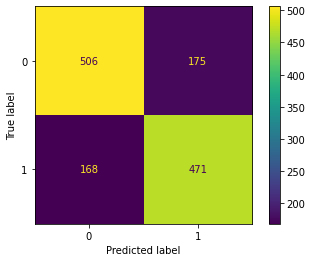

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm)
# disp = disp.plot(include_values=include_values, cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)
disp.plot()
plt.savefig("TimeEmbedding_confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
model.save("transformer_time2vec_2")

INFO:tensorflow:Assets written to: transformer_time2vec_2/assets


INFO:tensorflow:Assets written to: transformer_time2vec_2/assets


In [ ]:
# !tar -cvf  transformer_time2vec_2.tar.gz ./transformer_time2vec_2 
!cp transformer_time2vec_2.tar.gz ./drive/MyDrive/ICNA_hackathon/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! tar -cvf 

In [ ]:

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))  

# model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector, 
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)
]

In [ ]:
import matplotlib.pyplot as plt

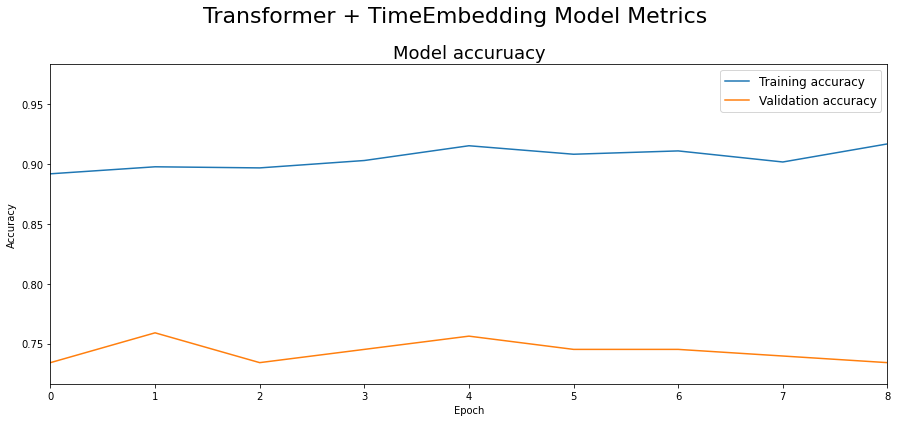

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
# ax1 = fig.add_subplot(311)
# ax1.set_xlim(0,8)
# ax1.plot(history.history['loss'], label='Training loss')
# ax1.plot(history.history['val_loss'], label='Validation loss')
# ax1.set_title("Model loss", fontsize=18)
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.legend(loc="best", fontsize=12)

# plt.savefig("Time2vec.png", dpi=300)


ax1 = fig.add_subplot(311)
ax1.set_xlim(0,8)
ax1.plot(history.history['binary_accuracy'], label='Training accuracy')
ax1.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
ax1.set_title("Model accuruacy", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="best", fontsize=12)

plt.savefig("Time2vec_accuracy.png", dpi=300)

#Plot MAE
# ax2 = fig.add_subplot(312)
# ax2.plot(history.history['mae'], label='Training MAE')
# ax2.plot(history.history['val_mae'], label='Validation MAE')
# ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Mean average error (MAE)')
# ax2.legend(loc="best", fontsize=12)

#Plot MAPE
# ax3 = fig.add_subplot(313)
# ax3.plot(history.history['mape'], label='Training MAPE')
# ax3.plot(history.history['val_mape'], label='Validation MAPE')
# ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
# ax3.set_xlabel('Epoch')
# ax3.set_ylabel('Mean average percentage error (MAPE)')
# ax3.legend(loc="best", fontsize=12)